### Init

In [49]:
!pip install imbalanced-learn

In [50]:
!pip install plotly

In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import seaborn as sns

In [52]:
%matplotlib inline
import plotly.io as pio
pio.renderers.default = 'iframe'

### Get and format data

In [53]:
df_raw = pd.read_csv("heart.csv")

df_raw.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [54]:
df = df_raw.copy()
df = df.rename(columns={"Residence_type": "residence_type"})


df = df.drop(columns=['id'], axis=1)

# Male = 0, Female = 1
df['gender'] = np.where(df['gender'] == 'Male', 0, 1)

# Yes = 0, No = 1
df['ever_married'] = np.where(df['ever_married'] == 'Yes', 0, 1)

# Urban = 0, Rural = 1
df['residence_type'] = np.where(df['residence_type'] == 'Urban', 0, 1)

# LabelEncoder
# work_type ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
# smoking_status ['never smoked' 'formerly smoked' 'Unknown' 'smokes']
le = LabelEncoder()
df['work_type'] = le.fit_transform(df['work_type'])
df['smoking_status'] = le.fit_transform(df['smoking_status'])

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,28.0,0,0,0,2,0,79.53,31.1,2,0
1,0,33.0,0,0,0,2,1,78.44,23.9,1,0
2,1,42.0,0,0,0,2,1,103.00,40.3,0,0
3,0,56.0,0,0,0,2,0,64.87,28.8,2,0
4,1,24.0,0,0,1,2,1,73.36,28.8,2,0


### Get train and test

In [55]:
data = df.drop(columns=['stroke'], axis=1)
target = df[['stroke']]

In [56]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)

In [57]:
sm = SMOTE(random_state=1)
rus = RandomUnderSampler(random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)

### Processing

#### Checking PCA

In [58]:
scaler = StandardScaler()
x_train_pca =  pd.DataFrame(scaler.fit_transform(x_train), index=x_train.index, columns=x_train.columns)
x_test_pca =  pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

x_train_pca.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
13533,0.866773,-0.177869,-0.350605,-0.250785,-0.461431,-0.074917,-0.972758,-0.315962,-0.133171,1.508914
5549,-1.153705,-2.197414,-0.350605,-0.250785,2.167171,2.035249,-0.972758,-0.141575,-1.807575,-1.477499
465,-1.153705,0.103928,-0.350605,-0.250785,-0.461431,-2.185083,1.028005,-0.293184,0.468315,0.513443
1134,0.866773,-0.083937,-0.350605,-0.250785,-0.461431,-2.185083,-0.972758,0.708315,1.947643,-1.477499
4958,0.866773,-0.976294,-0.350605,-0.250785,-0.461431,-0.074917,1.028005,-0.225339,-0.832194,0.513443


In [59]:
n_fatores = x_train_pca.shape[1]
pca = PCA(n_components=n_fatores)

pca.fit(x_train_pca)

PCA(n_components=10)

In [60]:
pca.explained_variance_ratio_

array([0.22509195, 0.13108059, 0.10389816, 0.10184972, 0.09084947,
       0.08623516, 0.08386322, 0.07242101, 0.06641589, 0.03829483])

In [61]:
fatores = [f'F{i+1}' for i in range(n_fatores) ]
fatores

['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10']

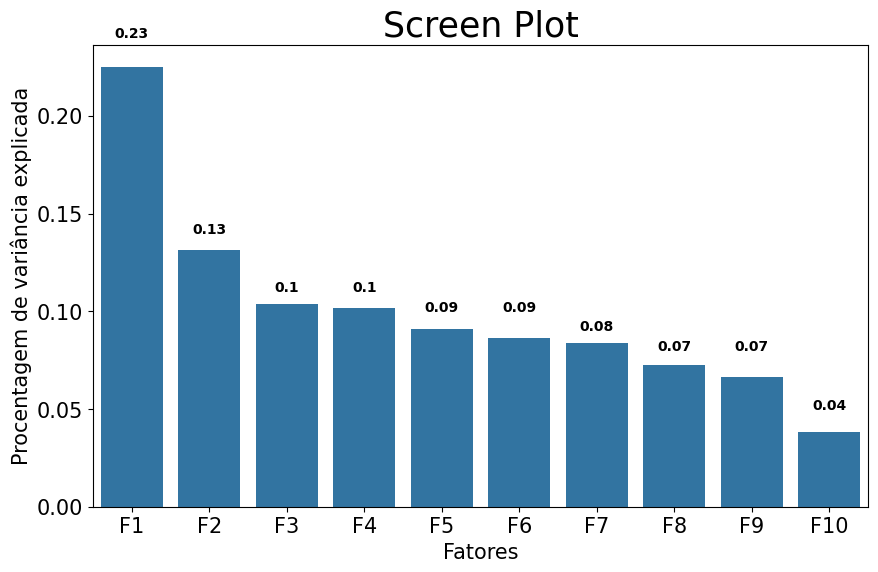

In [62]:
# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=fatores, y=pca.explained_variance_ratio_)

# Add text annotations
for i, v in enumerate(np.around(pca.explained_variance_ratio_, decimals=2)):
    ax.text(i, v + 0.01, str(v), color='black', ha='center', fontweight='bold')

# Add title and labels
ax.set_title("Screen Plot", fontsize=25)
ax.set_xlabel("Fatores", fontsize=15)
ax.set_ylabel("Procentagem de variância explicada", fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

plt.show()

In [63]:
autovalores = pca.explained_variance_ratio_ * n_fatores
autovalores

array([2.25091951, 1.31080588, 1.03898159, 1.01849719, 0.90849471,
       0.86235158, 0.83863224, 0.72421013, 0.66415888, 0.38294829])

In [64]:
# Com o método de raízes latentes, defina quantos fatores serão utilizados para criar 
# o ranking e imprima o Screenplot.
# http://www.leg.ufpr.br/lib/exe/fetch.php/disciplinas:ppgea2012:pca_teoria.pdf
# Seleção do número de componentes
# * Kaiser ou Método da Raiz Latente: autovalores maiores que 1 (Johnson = 0,7);
# Selecionamos apenas fatores que possuem autovalor > 1, pois assim já teremos um PCA que 'explica' 
# em torno de 98% do conjunto de dados

fatores_selecionados = ['Fator selecionado' if autovalor > 1 else 'Fator não selecionado' for autovalor in autovalores]
fatores_selecionados

['Fator selecionado',
 'Fator selecionado',
 'Fator selecionado',
 'Fator selecionado',
 'Fator não selecionado',
 'Fator não selecionado',
 'Fator não selecionado',
 'Fator não selecionado',
 'Fator não selecionado',
 'Fator não selecionado']

In [65]:
varianca_acumulada = [sum(pca.explained_variance_ratio_[0:i+1]) for i in range(n_fatores)]
varianca_acumulada

[0.2250919511114624,
 0.35617253946491445,
 0.46007069826874597,
 0.5619204171198362,
 0.652769887836179,
 0.7390050454837264,
 0.8228682699526165,
 0.8952892829368888,
 0.9617051705851809,
 0.9999999999999999]

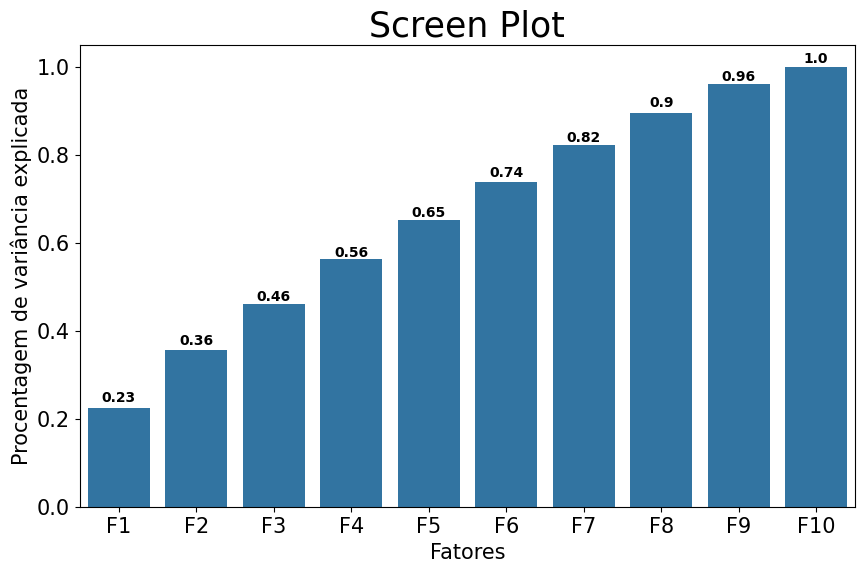

In [66]:
# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=fatores, y=varianca_acumulada)

# Add text annotations
for i, v in enumerate(np.around(varianca_acumulada, decimals=2)):
    ax.text(i, v + 0.01, str(v), color='black', ha='center', fontweight='bold')

# Add title and labels
ax.set_title("Screen Plot", fontsize=25)
ax.set_xlabel("Fatores", fontsize=15)
ax.set_ylabel("Procentagem de variância explicada", fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

plt.show()


#### Checking post prunning

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

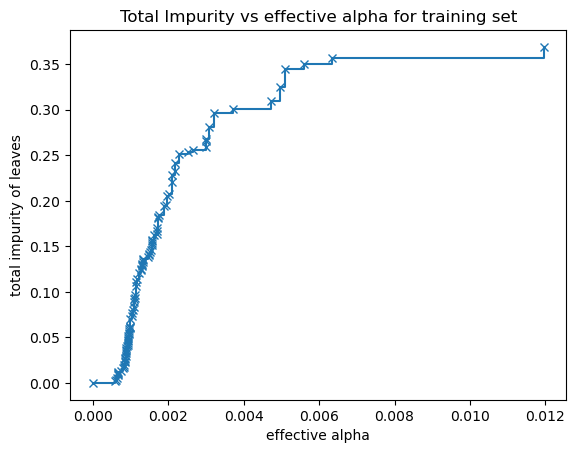

In [67]:
dt = DecisionTreeClassifier(random_state=0, class_weight='balanced', max_features='sqrt')
pca = PCA(n_components=7)
x_train_pca = pca.fit_transform(x_train_pca)
x_test_pca = pca.transform(x_test_pca)

path = dt.cost_complexity_pruning_path(x_train_pca, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="x", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [68]:
clfs = []
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=0, class_weight='balanced', max_features='sqrt', ccp_alpha=ccp_alpha)
    dt.fit(x_train_pca, y_train)
    clfs.append(dt)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0327441095511494


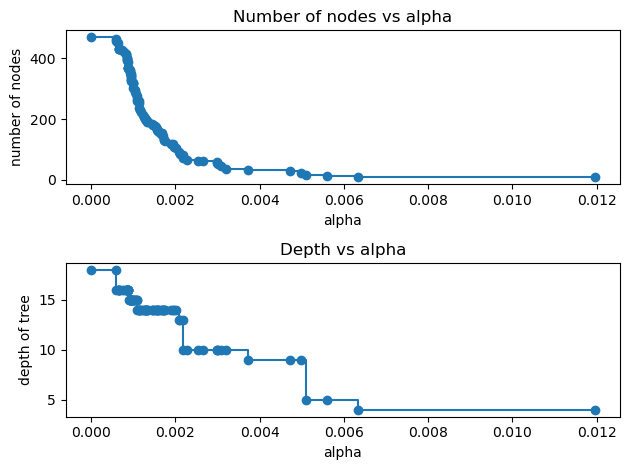

In [69]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

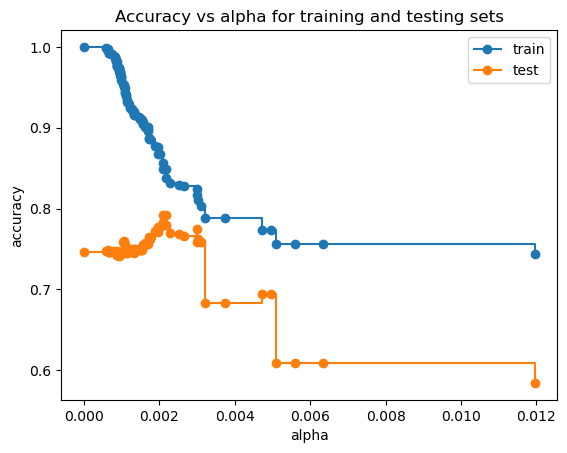

In [70]:
train_scores = [clf.score(x_train_pca, y_train) for clf in clfs]
test_scores = [clf.score(x_test_pca, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

#### Training

In [71]:
dt = DecisionTreeClassifier(random_state=0, class_weight='balanced', max_features='sqrt')
scaler = StandardScaler()
pca = PCA()

In [72]:
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("dt", dt)])

param_grid = {
    #'dt__max_depth': list(range(1, 11, 1)),
    'dt__min_samples_leaf': [1, 2, 3],
    'dt__max_leaf_nodes': [None, 5, 10],
    'pca__n_components': range(1, n_fatores + 1, 1)
}

grid_dt = GridSearchCV(pipe, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_dt.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('dt',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               max_features='sqrt',
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'dt__max_leaf_nodes': [None, 5, 10],
                         'dt__min_samples_leaf': [1, 2, 3],
                         'pca__n_components': range(1, 11)},
             scoring='recall')

In [73]:
print(f"Melhores parâmetros KNN: {grid_dt.best_params_}")

Melhores parâmetros KNN: {'dt__max_leaf_nodes': 5, 'dt__min_samples_leaf': 1, 'pca__n_components': 10}


### Testing

In [74]:
grid_dt.score(x_test, y_test)

0.832

In [75]:
y_pred = grid_dt.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      2936
           1       0.11      0.83      0.19       125

    accuracy                           0.71      3061
   macro avg       0.55      0.77      0.51      3061
weighted avg       0.95      0.71      0.80      3061



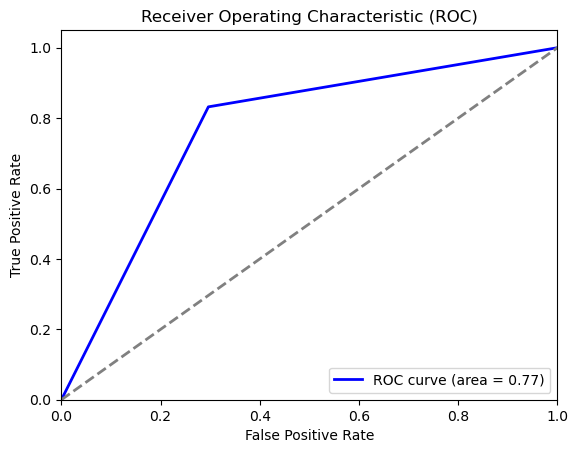

In [76]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

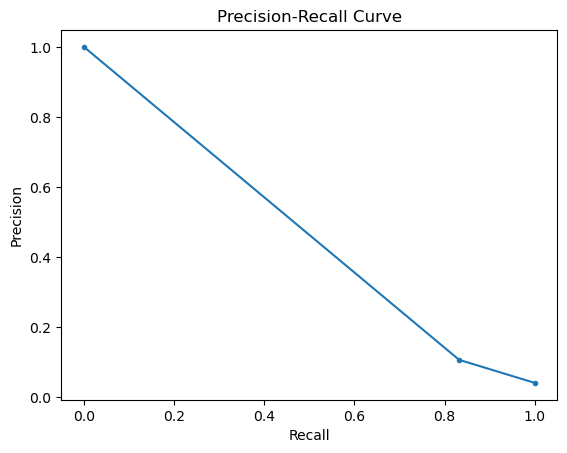

In [77]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

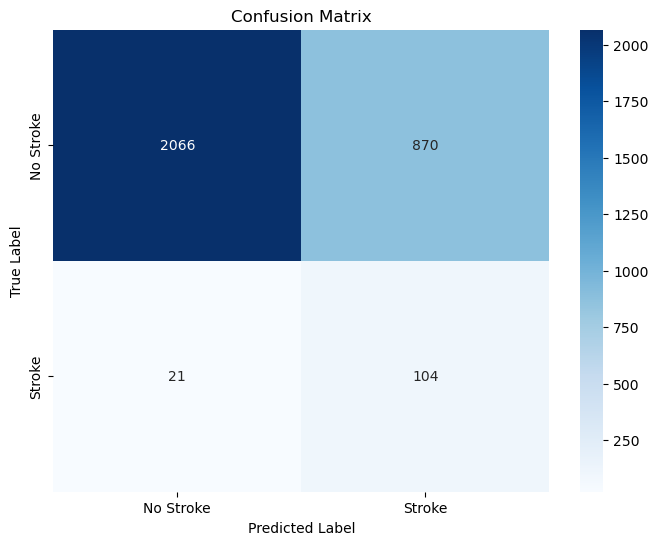

In [78]:
cm = confusion_matrix(y_test, y_pred)

# Define the labels
labels = ['No Stroke', 'Stroke']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()